In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Estimate of $p_0$ and $Z$
$p_0 = \frac{\pi\tan{\theta_0}}{c\lambda(B_2-B_1)}$

In [3]:
c = 4.63e14 # T-1 m-2
theta_0 = np.deg2rad(5.5) # rad
wavelength = 2.165e-10 # m
delta_B = 4.68e-3 # T
# Distance between centers of the 2 flippers
L = 2 # m

p_0 = np.pi * np.tan(theta_0) / (c * wavelength * delta_B)
# This is used for numerical stability in the fit
p_inv = 1 / p_0
p_0, p_inv

(0.0006448252299813332, 1550.8078057506352)

$z = \frac{c\lambda^2(B_2-B_1)L}{\pi\tan{\theta_0}}$

In [4]:
z = c * wavelength ** 2 * delta_B * L / (np.pi * np.tan(theta_0))
z * 1e6

0.6714997798900252

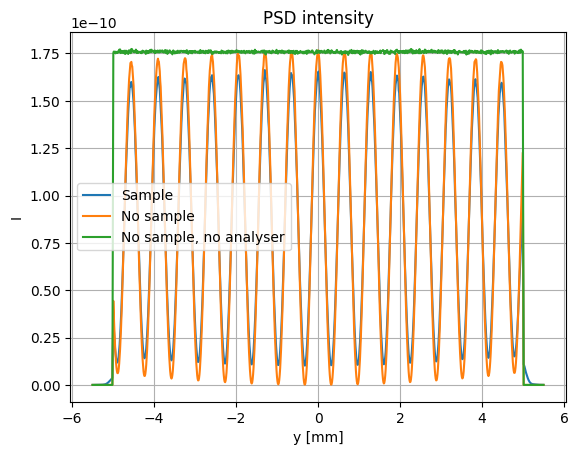

In [23]:
y_flat, I_flat = np.genfromtxt('PSD_no_mod_no_sample.dat', delimiter=' ', usecols=(0,1), unpack=True)
y, I = np.genfromtxt('PSD_mod_no_sample.dat', delimiter=' ', usecols=(0,1), unpack=True)
y_sample, I_sample = np.genfromtxt('PSD.dat', delimiter=' ', usecols=(0,1), unpack=True)


y_sample*=1e-2
y*=1e-2
y_flat*=1e-2

plt.plot(y_sample*1e3, I_sample,'-',  label='Sample')
plt.plot(y*1e3, I, label='No sample')
plt.plot(y_flat*1e3, I_flat,  label='No sample, no analyser')

plt.xlabel('y [mm]')
plt.ylabel('I')
plt.title('PSD intensity')
plt.grid(True)  # Add grid
plt.legend()
plt.show()

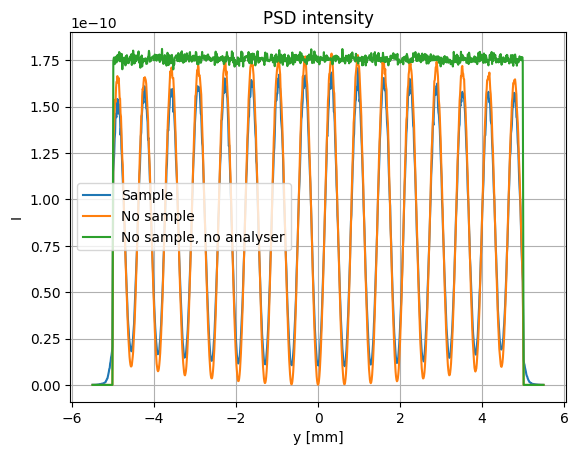

In [19]:
y_flat, I_flat = np.genfromtxt('SEMSANS_Delft_data/no-sample-no-pol.dat', delimiter=' ', usecols=(0,1), unpack=True)
y, I = np.genfromtxt('SEMSANS_Delft_data/pol.dat', delimiter=' ', usecols=(0,1), unpack=True)
y_sample, I_sample = np.genfromtxt('SEMSANS_Delft_data/sample-pol.dat', delimiter=' ', usecols=(0,1), unpack=True)


y_sample*=1e-2
y*=1e-2
y_flat*=1e-2

plt.plot(y_sample*1e3, I_sample,'-',  label='Sample')
plt.plot(y*1e3, I, label='No sample')
plt.plot(y_flat*1e3, I_flat,  label='No sample, no analyser')

plt.xlabel('y [mm]')
plt.ylabel('I')
plt.title('PSD intensity')
plt.grid(True)  # Add grid
plt.legend()
plt.show()

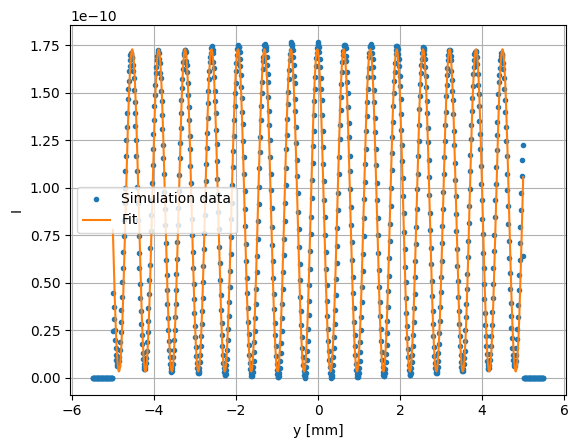

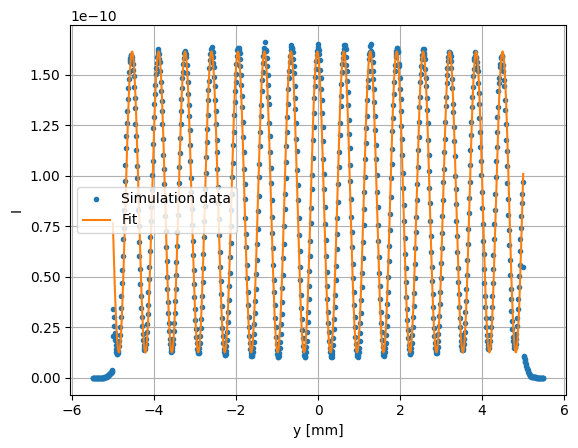

In [24]:
def indices_within_range(x, a, b):
    return np.where((x >= a) & (x <= b))[0]

def I_fit(y, a, b, p_inv, phi):
    return (a + b * np.cos(2*np.pi * y * p_inv+phi))

def I_mod(y, I_0, A, p_0, phi):
    return I_0 * (1 + A * np.cos(2*np.pi * y / p_0+phi))

def fit_pattern(y, I, plot=False):
    indices = indices_within_range(y, -0.005, 0.005)

    # The DC component can be expected to be the mean
    mean = np.mean(I[indices])
    # The amplitude will be roughly the max minus the mean
    amplitude = np.max(I[indices]) - mean

    # bounds = ([0.7 * mean, 0.7 * amplitude, 0.8*p_inv,0.0], [1.3 * mean, 1.3 * amplitude, 1.2*p_inv,2*np.pi])
    guess =  [mean, amplitude, p_inv, 0]
    popt, pcov = curve_fit(I_fit, y[indices], I[indices],p0=guess)
    I_0 = popt[0]
    diag = np.diagonal(pcov)
    dI_0 = diag[0]
    A_0 = popt[1] / popt[0]
    dA_0 = np.sqrt((popt[1]*diag[0]/popt[0]**2)**2+diag[1]**2)
    p_0_fit = 1/popt[2]
    dp_0_fit = diag[2] / popt[2]**2
    phi = popt[3]
    dphi = diag[3]
    I_0, A_0, p_0_fit
    if plot:    
        I_fitted = I_mod(y[indices],*[I_0, A_0, p_0_fit,phi])
        plt.plot(y*1e3, I, '.', label='Simulation data')
        plt.plot(y[indices]*1e3, I_fitted, label='Fit')
        plt.xlabel('y [mm]')
        plt.ylabel('I')
        plt.grid(True)
        plt.legend()
        plt.show()
    return [I_0,A_0,p_0_fit, phi], [dI_0,dA_0,dp_0_fit, dphi]
params, dparams = fit_pattern(y,I,True)
params_sample, dparams_sample = fit_pattern(y_sample,I_sample,True)

In [25]:
A_0 = params[1]
dA_0 = dparams[1]
A_z = params_sample[1]
dA_z = dparams_sample[1]
R = A_z/A_0 
dR = np.sqrt(dA_z**2 + (A_z*dA_0/A_0**2)**2)
R, dR        

(0.8890066672780659, 1.2232523512603874e-15)

$\frac{A(z)}{A_0} = e^{s_t(G(z)-1)} \implies G(z) = \frac{\ln{\frac{A(z)}{A_0}}}{s_t} + 1$

In [26]:
s_t = 0.38 # for the specified sample, see 2021 sim paper
G_z = np.log(R) / s_t + 1
G_z

0.6903933059315785